# Fallback - Insert Retention Scores NHL-Jets
* StellarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 29, 2022

In [37]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

In [38]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [39]:
LKUPCLIENTID = "92"
DBNAME = "stlrnhljets"
ENV = "qa-app"
SCORINGYEAR = 2021

In [40]:
df = helpers.get_retention_dataset(
    cluster = ENV,
    database = DBNAME,
    lkupclientid = LKUPCLIENTID,
    start_year = 2010,
    end_year = 2022
)

df.shape

(53858, 24)

In [41]:
df.year.value_counts()

2018    7515
2019    7386
2017    6969
2016    6834
2015    6320
2013    6318
2014    6272
2021    6244
Name: year, dtype: int64

In [42]:
df.head()

,lkupclientid,clientcode,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,...,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,92,NHLJETS,8760,2019,Full Season,13232.00,2020-03-09,0.99,248,4015,...,0,0,75,5.11,1.89,0.37,Unknown,6,0,0
1,92,NHLJETS,15178,2021,Full Season,2657.76,2022-04-08,0.74,82,4745,...,1,2,58,1.16,0.11,0.09,Unknown,6,0,1
2,92,NHLJETS,18250,2021,Partial Season,1140.00,2022-03-22,0.90,45,6205,...,0,0,32,1.00,0.10,0.10,Unknown,4,0,0
3,92,NHLJETS,18495,2021,Full Season,13712.16,2022-04-24,0.89,82,6570,...,1,0,144,1.83,0.04,0.02,Unknown,5,0,1
4,92,NHLJETS,19618,2019,Half Season,2788.00,2020-03-09,1.00,250,4015,...,0,0,27,0.25,0.00,0.00,Unknown,7,0,0


### We should specify the features used in our model:

In [43]:
# choose the features for the stellar base retention model
features = [
    "recentdate",
	"clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
	"disttovenue",
    "inperson_contact",
	"missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
	"recency",
	"source_tenure",
	"totalspent",
	"isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] < SCORINGYEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (40472, 16)
Unseen Data For Predictions: (7142, 16)



In [44]:
print(df_dataset.year.value_counts())

2018    7515
2019    7386
2017    6969
2016    6834
2015    6320
2013    6318
2014    6272
Name: year, dtype: int64


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [45]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
		"disttovenue",
        "inperson_contact",
		"missed_games_1",
		"missed_games_2",
		"missed_games_over_2",
		"recency",
		"source_tenure",
		"totalspent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [46]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9483,0.9645,0.9691,0.9645,0.9668,0.8497,0.8498,0.2140
gbc,Gradient Boosting Classifier,0.9474,0.9583,0.9716,0.9612,0.9663,0.8460,0.8463,1.2350
xgboost,Extreme Gradient Boosting,0.9457,0.9640,0.9655,0.9647,0.9651,0.8431,0.8431,0.6280
rf,Random Forest Classifier,0.9307,0.9532,0.9448,0.9652,0.9549,0.8050,0.8059,0.5000
lr,Logistic Regression,0.9101,0.9216,0.9338,0.9496,0.9414,0.7479,0.7496,0.2740


In [47]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9172,0.9303,0.9387,0.9540,0.9463,0.7656,0.7661
1,0.9294,0.9418,0.9518,0.9571,0.9544,0.7974,0.7974
2,0.9189,0.9161,0.9473,0.9483,0.9478,0.7660,0.7660
3,0.9224,0.9262,0.9484,0.9516,0.9500,0.7769,0.7770
4,0.9201,0.9240,0.9465,0.9504,0.9485,0.7705,0.7705
5,0.9151,0.9188,0.9443,0.9464,0.9453,0.7557,0.7557
6,0.9064,0.9118,0.9364,0.9427,0.9396,0.7321,0.7322
7,0.9128,0.9129,0.9428,0.9449,0.9438,0.7490,0.7490
8,0.9227,0.9263,0.9450,0.9550,0.9500,0.7797,0.7799


### Let's load in our 2021 season data and get retention scores using the model:

In [48]:
df_inference = df.loc[df["year"] >= SCORINGYEAR]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(6244, 16)

In [49]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7069,0.7112,0.7730,0.7920,0.7824,0.3340,0.3343


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7018,0.7387,0.7669,0.7895,0.7780,0.3242,0.3245


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6893,0.7061,0.7417,0.7896,0.7649,0.3082,0.3096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6773,0.7251,0.6933,0.8060,0.7454,0.3115,0.3182


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5998,0.5991,0.6259,0.7459,0.6806,0.1556,0.1599


### We can create some histograms to visualize each model distribution:

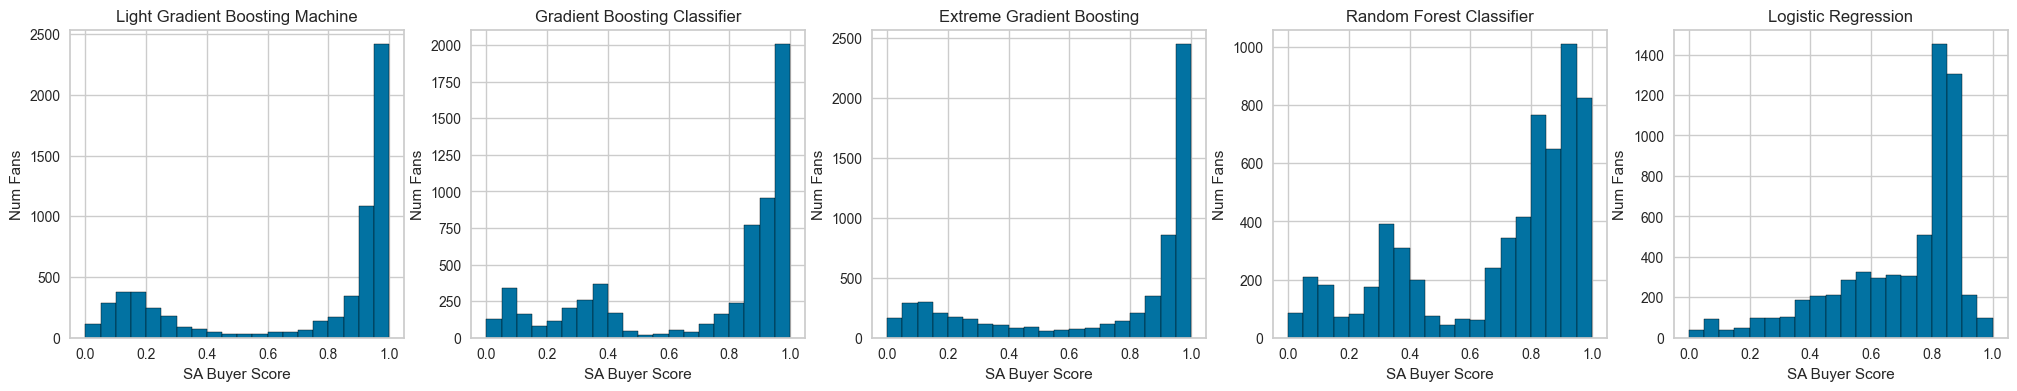

In [50]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [51]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


1    4153
0    2045
Name: Label, dtype: int64
1    4133
0    2096
Name: Label, dtype: int64
1    3997
0    2077
Name: Label, dtype: int64
1    3660
0    2530
Name: Label, dtype: int64
1    3570
0    2639
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [52]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6198 entries, 1 to 53359
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   recentdate           6198 non-null   datetime64[ns]
 1   clientcode           6198 non-null   object        
 2   dimcustomermasterid  6198 non-null   int64         
 3   lkupclientid         6198 non-null   int64         
 4   productgrouping      6198 non-null   object        
 5   year                 6198 non-null   int64         
 6   attendancepercent    6198 non-null   float64       
 7   disttovenue          6198 non-null   float64       
 8   inperson_contact     6198 non-null   int64         
 9   missed_games_1       6198 non-null   object        
 10  missed_games_2       6198 non-null   object        
 11  missed_games_over_2  6198 non-null   object        
 12  recency              6198 non-null   int64         
 13  source_tenure        6198 non-nu

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [53]:
CONN = helpers.get_redshift_connection(ENV, DBNAME)

### Insert the scores into the customerretentionscores table in RedShift:

In [54]:
cur = CONN.cursor()

batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancepercent)},
                {str(row.dimcustomermasterid)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupclientid)},
                '{str(row.recentdate)}',
                '{str(row.productgrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 6209 NEW RETENTION SCORES TO DATABASE: stlrnhljets (92)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 > I